In [45]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm
from p_tqdm import p_map
import librosa
import librosa.display
import random
from skimage.transform import resize
import warnings

In [46]:
warnings.filterwarnings('ignore')

### LISTAGE DES FICHIERS CONTENUS DANS LE DATASET

In [47]:
def get_audio_list(location = "/Users/george.pied/Code/clumzy/tag_my_techno/datasets", max_samples = 250, random_state = 420):
    audio_files = np.empty((0,3))
    # LES EXTENSIONS QUE L'ON CHERCHE
    exts = ['*.mp3', '*.aiff', '*.flac','*.wav']
    # LES DIFFERENTS SOUS-DOSSIERS (ON NE VERIFIE PAS QU'ILS CONTIENNENT DES ELEMENTS)
    sub_directories = [f.path for f in os.scandir(location) if f.is_dir()]
    for directory in sub_directories:
        # ON LISTE LES FICHIERS AUDIO TROUVES DANS LE SUB DIR
        sub_dir_files = [f for ext in exts for f in glob(os.path.join(directory, ext))]
        if len(sub_dir_files) > 0:
            # ON SEED
            random.seed(random_state)
            # ON MELANGE
            random.shuffle(sub_dir_files)
            # ON DUPLIQUE LES FICHIERS SI IL Y EN A PAS ASSEZ
            while len(sub_dir_files) < max_samples : sub_dir_files = sub_dir_files + sub_dir_files[:max_samples-len(sub_dir_files)]
            # ON RECUPERE DES SAMPLES
            sub_dir_samples = random.sample(sub_dir_files, k=max_samples)
            for sample in sub_dir_samples:
                #ON RENVOIE
                # 0 - CHEMIN DU FICHIER
                # 1 - GENRE
                # 2 - NOMBRE DE FOIS OU IL APPARAIT AFIN DE BIEN METTRE UN OFFSET
                audio_files = np.append(audio_files, [[sample, os.path.basename(directory), np.count_nonzero(audio_files[-len(sub_dir_files):] == sample)]], axis=0)
    return audio_files            


### FEATURE MAKER FUNCTION & SCALER FUNCTION

Ces fonctions nous servent à scaler et créer **l'image feature** pour un fichier donné.

In [48]:
import numpy as np
import pydub as pydub
import librosa
import warnings
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def rgb_transform(data):
    """Une fonction qui prend en entrée une image au format Array en RGB, et qui va normaliser
    selon une formule MinMax scalée sur 255.

    Args:
        data (numpy.array): Une image au format numpy Array.

    Returns:
        numpy.array: L'image normalisée.
    """
    return (((data+abs(data.min()))/(data+abs(data.min())).max())*255).astype(np.uint8)

def get_from_pydub(file, num_blocks=5, num_samples = 4, sample_length=2, sample_rate=44100):
    """
    Extracts segments from an audio file and calculates their BPM (Beats Per Minute) to determine measure length for music genre classification.

    This function reads an audio file, converts it to mono channel, sets a specified sample rate, normalizes the audio data,
    calculates the BPM, determines the length of a musical measure in seconds, and then extracts segments of audio
    based on the calculated measure length. It returns these segments along with the measure length for further processing.

    Parameters:
    - file (str): Path to the audio file to process.
    - num_blocks (int, optional): Number of blocks to divide the song into. Defaults to 5.
    - num_samples (int, optional): Number of samples to extract per block. Defaults to 4.
    - sample_length (int, optional): Length of each sample in measures. Defaults to 2.
    - sample_rate (int, optional): Sample rate for the audio file. Defaults to 44100 Hz.

    Returns:
    - tuple: A tuple containing two elements:
        - list: Segments extracted from the audio file, ready for feature extraction.
        Each segment is a numpy array representing a portion of the audio waveform.
        - int: Length of a musical measure in samples, calculated based on the BPM of the song.

    The function processes the audio file to prepare it for genre classification by extracting relevant segments
    based on musical measures, which helps in aligning the analysis with the rhythmic structure of the music.
    It uses PyDub for initial processing and calculates BPM using a custom function to understand the tempo,
    aiding in the segmentation process.

    Example:
    >>> segments, measure_length = get_from_pydub("path/to/audio/file.mp3")
    >>> print(f"Number of segments: {len(segments)}, Measure length: {measure_length}")

    Note: The function assumes the audio file is stereo and converts it to mono for simplicity.
          It also normalizes the audio waveform to a range between -1 and 1 for consistency across files.
    """
    song:pydub.AudioSegment = pydub.AudioSegment.from_file(file).set_channels(1)
    # SET SAMPLE RATE TO sample_rate
    song = song.set_frame_rate(sample_rate)
    song_len = len(song) #on stocke la durée en ms
    song = np.array(song.get_array_of_samples())
    # normalize audio to -1, 1 in float32 for numpy
    song = song.astype(np.float32) / (2**15 - 1)
    bpm = calculate_bpm(song)
    #get length of a measure in seconds
    measure_length = int(60 / bpm * 4 * sample_rate)
    #convert length to scale of numpy indices
    start_points = np.linspace(
        start = 0, 
        stop = len(song)-1,
        endpoint= False, 
        num = num_blocks, 
        dtype=int) + int(len(song) / 6 / 2)
    segments = [[song[s + n * sample_length * measure_length:s + (n + 1) * sample_length * measure_length] for n in range(num_samples)] for s in start_points]
    return segments, measure_length

def segments_to_img(segments, hop_length=1024, sample_rate=44100, set_width:int|bool=256):
    """Transforms each segment of audio into an image.

    Args:
        segments (list of list of np.array): Segments of audio to transform.
        hop_length (int, optional): The hop length for the analysis. Defaults to 1024.
        sample_rate (int, optional): The sample rate of the audio. Defaults to 44100.

    Returns:
        list of list of np.array: Images corresponding to each audio segment.
    """
    def transform_segment_to_img(song_extract):
        """Transforms a single audio segment into an image."""
        warnings.filterwarnings('ignore')
        HOP_LENGTH = hop_length
        SAMPLING_RATE = sample_rate

        # Calculate Constant-Q
        constant_q_temp = librosa.cqt(song_extract, hop_length=HOP_LENGTH, sr=SAMPLING_RATE)
        constant_q = librosa.amplitude_to_db(np.abs(constant_q_temp))
    
        # Calculate MFCC
        mfcc_song = librosa.feature.mfcc(y=song_extract, n_mfcc=26, sr=SAMPLING_RATE, lifter=512, hop_length=HOP_LENGTH)

        # Calculate Chromagram
        chromacens = librosa.feature.chroma_cens(y=song_extract, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_chroma=36, win_len_smooth=5, C=constant_q_temp)
        #CREATION DE LA SHAPE FINALE A PARTIR DES PLUS GRANDES VALEURS DE NOS TROIS FEATURES
        # Create final image shape
        IM_HEIGHT = max(constant_q.shape[0], mfcc_song.shape[0], chromacens.shape[0])
        # COMME ICI C'EST EN FONCTION DU BPM QU'ON FAIT LES TRANCHES, ON S'ASSURE QU'ELLES AIENT TOUTES LA MEME TAILLE POUR LE MODELE
        if set_width:
            IM_WIDTH = set_width
        else:
            IM_WIDTH = max(constant_q.shape[1], mfcc_song.shape[1], chromacens.shape[1])
        IM_SHAPE = (IM_HEIGHT, IM_WIDTH)

        r = rgb_transform(resize(constant_q, IM_SHAPE, anti_aliasing=None, mode="reflect", order=0)).astype(np.uint8)
        g = rgb_transform(resize(mfcc_song, IM_SHAPE, anti_aliasing=None, mode="reflect", order=0)).astype(np.uint8)
        b = rgb_transform(resize(chromacens, IM_SHAPE, anti_aliasing=None, mode="reflect", order=0)).astype(np.uint8)

        rgb = np.dstack((r, g, b)).astype(np.uint8)
        return rgb

    # Transform each segment in the list of lists
    images = [[transform_segment_to_img(segment) for segment in block] for block in segments]
    return images

def calculate_bpm(audio_series, sr=44100):
    """
    Calculates BPM using librosa's beat tracking.
    """
    tempo, _ = librosa.beat.beat_track(y=audio_series, sr=sr)
    return round(tempo, 2)

def plot_segments_images(images):
    """
    Plots the images of audio segments in a grid format with blocks as x and segments as y,
    enhanced for better visual distinction and aesthetics.

    Args:
        images (list of list of np.array): Images corresponding to each audio segment.
    """
    num_blocks = len(images)
    num_segments = len(images[0]) if num_blocks > 0 else 0

    # Adjust figure size based on the number of blocks and segments for better readability
    figsize = (num_blocks * 4, num_segments * 3) if num_blocks > 5 else (num_blocks * 3, num_segments * 2)
    
    fig, axes = plt.subplots(num_segments, num_blocks, figsize=figsize, constrained_layout=True)

    title_bg_colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow', 'lightpink', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightsteelblue', 'lightseagreen']

    for i, block in enumerate(images):
        for j, img in enumerate(block):
            # Select the current axis object based on the number of segments
            ax = axes[j, i] if num_segments > 1 else axes[i]
            ax.imshow(img)

            # Remove axis ticks for cleaner look
            ax.axis('off')
            # Enhanced title with block and segment information
            title_bg_color = title_bg_colors[i % len(title_bg_colors)]
            ax.set_title(f'Block {i+1}, Segment {j+1}', fontsize=10, pad=10, backgroundcolor=title_bg_color)
    
    # Add a grid to the plot
    for ax in axes.flat:
        ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
    
    # Adjust layout to prevent overlap and ensure tight spacing
    plt.tight_layout()
    plt.show()

    import numpy as np
import pydub

def get_slice_indices_from_pydub(file, num_blocks=5, num_samples=4, sample_length=2, sample_rate=44100):
    """
    Calculates the slice indices for segments from an audio file based on the BPM (Beats Per Minute) to determine measure length for music genre classification.

    This function reads an audio file, converts it to mono channel, sets a specified sample rate, normalizes the audio data,
    calculates the BPM, determines the length of a musical measure in seconds, and then calculates the slice indices
    for segments of audio based on the calculated measure length.

    Parameters:
    - file (str): Path to the audio file to process.
    - num_blocks (int, optional): Number of blocks to divide the song into. Defaults to 5.
    - num_samples (int, optional): Number of samples to extract per block. Defaults to 4.
    - sample_length (int, optional): Length of each sample in measures. Defaults to 2.
    - sample_rate (int, optional): Sample rate for the audio file. Defaults to 44100 Hz.

    Returns:
    - list: A list of lists containing the start and end indices for each segment.
    """
    song = pydub.AudioSegment.from_file(file).set_channels(1)
    song = song.set_frame_rate(sample_rate)
    song_len = len(song)  # Duration in ms
    song = np.array(song.get_array_of_samples())
    song = song.astype(np.float32) / (2**15 - 1)  # Normalize audio to -1, 1 in float32 for numpy

    bpm = calculate_bpm(song)
    measure_length = int(60 / bpm * 4 * sample_rate)  # Length of a measure in samples

    start_points = np.linspace(
        start=0,
        stop=len(song) - 1,
        endpoint=False,
        num=num_blocks,
        dtype=int
    ) + int(len(song) / 6 / 2)

    slice_indices = [
        [(s + n * sample_length * measure_length, s + (n + 1) * sample_length * measure_length) for n in range(num_samples)]
        for s in start_points
    ]

    return slice_indices

def plot_waveform_with_slices(file, slice_indices, sample_rate=44100):
    """
    Plots the waveform of the song with overlaid blocks, segments, and samples, recolored based on the block.

    Args:
        file (str): Path to the audio file to process.
        slice_indices (list): List of lists containing the start and end indices for each segment.
        sample_rate (int, optional): Sample rate for the audio file. Defaults to 44100 Hz.
    """
    # Load the song
    song = pydub.AudioSegment.from_file(file).set_channels(1)
    song = song.set_frame_rate(sample_rate)
    song = np.array(song.get_array_of_samples())
    song = song.astype(np.float32) / (2**15 - 1)  # Normalize audio to -1, 1 in float32 for numpy

    # Define a list of darker colors for the blocks
    block_colors = ['darkred', 'darkblue', 'darkgreen', 'darkorange', 'darkmagenta', 'darkcyan', 'darkgoldenrod', 'dimgray', 'darkslateblue', 'darkseagreen']

    # Plot the waveform
    plt.figure(figsize=(15, 5))
    plt.plot(song, color='black', alpha=0.6, label='Waveform')

    # Overlay the blocks, segments, and samples
    for block_idx, block in enumerate(slice_indices):
        block_color = block_colors[block_idx % len(block_colors)]
        for segment_idx, (start, end) in enumerate(block):
            plt.axvspan(start, end, color=block_color, alpha=0.5, label=f'Block {block_idx+1}, Segment {segment_idx+1}' if segment_idx == 0 else "")

    # Add labels and legend
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.title('Waveform with Overlaid Blocks, Segments, and Samples')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')
    plt.grid(True)
    plt.show()


### EXEMPLE D'UNE CREATION DE FEATURES

In [49]:
SONG_NUM = 2
audio_files = get_audio_list(max_samples=5)

In [50]:
num_blocks=4
num_samples = 8
sample_length=2
sample_rate=44100
segments, measure_length = get_from_pydub(
    file=audio_files[SONG_NUM, 0],
    num_blocks=num_blocks,
    num_samples=num_samples,
    sample_length=sample_length,
    sample_rate=sample_rate)


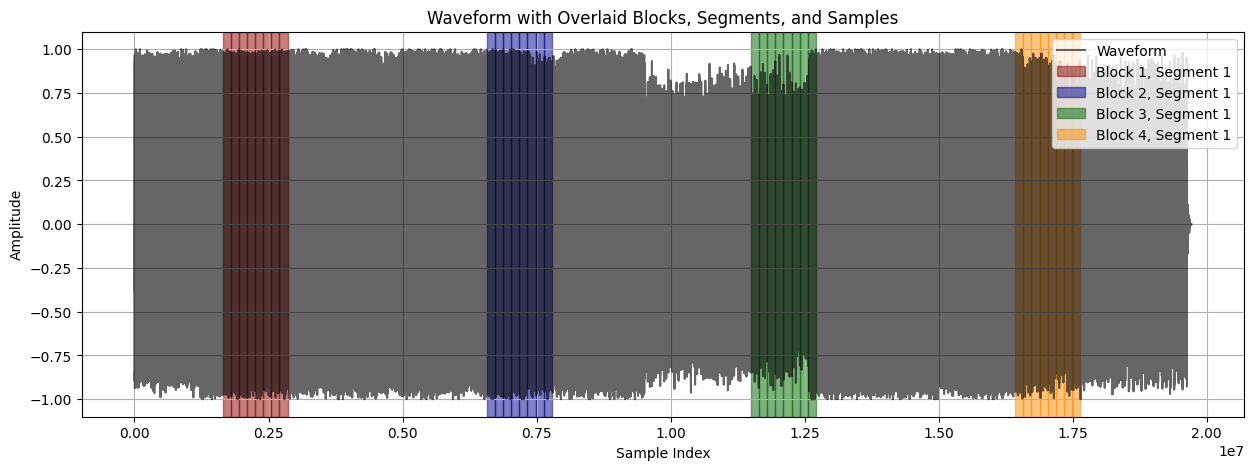

In [51]:
slices = get_slice_indices_from_pydub(file=audio_files[SONG_NUM, 0],
    num_blocks=num_blocks,
    num_samples=num_samples,
    sample_length=sample_length,
    sample_rate=sample_rate)
plot_waveform_with_slices(audio_files[SONG_NUM, 0], slices)

In [52]:
processed_segments = segments_to_img(
    segments, 
    hop_length=512, 
    sample_rate=44100)

In [53]:
np.array(processed_segments).shape

(4, 8, 84, 256, 3)

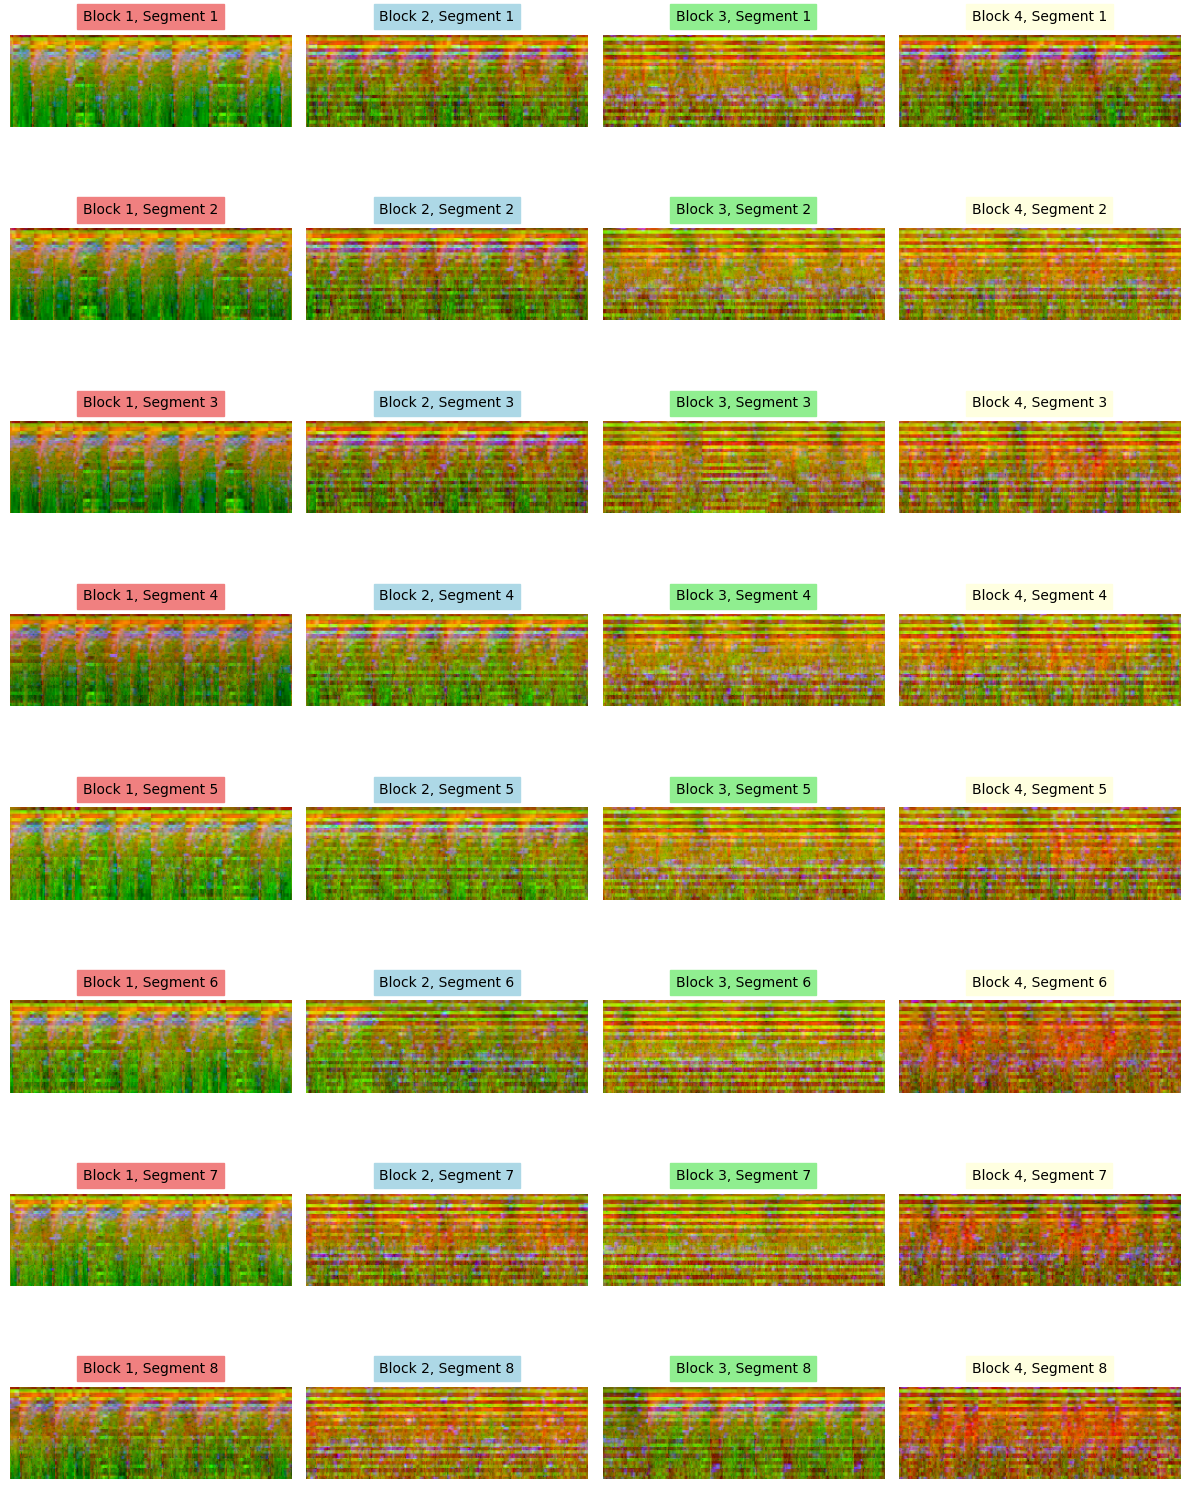

In [54]:
# Assuming `processed_segments` is the output from `segments_to_img`
plot_segments_images(processed_segments)

### CREATION DES FEATURES POUR LA LISTE DES MUSIQUES

In [ ]:
def song_to_img()

In [ ]:
audio_files = get_audio_list(max_samples=500)
HOW_MANY = len(audio_files)
X = np.array(p_map(
    song_to_img,
    audio_files[:, 0],
    [1024]*HOW_MANY,
    [10]*HOW_MANY,
    [3]*HOW_MANY,
    [44100]*HOW_MANY,
    audio_files[:, 2],
    [MAX_OFFSET]*HOW_MANY), dtype=np.uint8)
print(X.shape)

y = audio_files


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

: 

### EXPORT DES FEATURES

In [ ]:
import pickle
pickle.dump(X, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images3_big.pkl"), "wb" ) )
pickle.dump(y, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","target3_big.pkl"), "wb" ) )

In [ ]:
X1 = X[:2625]
X2 = X[2625:5250]
X3 = X[5250:7875]
X4 = X[7875:]
pickle.dump(X1, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images3_big_part1.pkl"), "wb" ) )
pickle.dump(X2, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images3_big_part2.pkl"), "wb" ) )
pickle.dump(X3, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images3_big_part3.pkl"), "wb" ) )
pickle.dump(X4, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images3_big_part4.pkl"), "wb" ) )